In [1]:
!mkdir -p ~/.kaggle # make a folder in kaggle root
!cp kaggle.json ~/.kaggle # copy paste kaggle.json to folder kaggle 

!mkdir ./kaggle # make a folder kaggle in the same location (not in root)
!mv ./kaggle.json ./kaggle # move the file kaggle.json to folder kaggle


In [2]:
!chmod 600 ~/.kaggle/kaggle.json # permission access
!ls ~/.kaggle # check list data in folder kaggle

kaggle.json


In [3]:
!kaggle datasets download -d omkargurav/face-mask-dataset

 89% 145M/163M [00:00<00:00, 280MB/s]
100% 163M/163M [00:00<00:00, 227MB/s]


In [4]:
!unzip -q /content/face-mask-dataset.zip -d images # unzip to new folder images

# i. Introduction

Name : Dheny Ramadianindra 

Batch : FTDS-010 

Dataset : Face Mask Detection

Objective:

- Able to understand the concept of Computer Vision.
- Able to prepare the data for model in Computer Vision.
- Able to implemented Artificial Neural Network with the data.
- Able to analyze and explained the layer.

Data source : https://www.kaggle.com/datasets/omkargurav/face-mask-dataset

Model deployment : https://dheny-ftds10-cnn.herokuapp.com/

# ii. Import Libraries

In [5]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')


# iii. Data Loading

In [6]:
os.listdir('/content/images/data')

['with_mask', 'without_mask']

In [7]:
main_path = '/content/images/data'

In [8]:
with_mask = os.path.join(main_path, 'with_mask')
without_mask = os.path.join(main_path, 'without_mask')

In [9]:
print('Dataset: \n' + '='*50)
num_with = len(os.listdir(with_mask))
num_without = len(os.listdir(without_mask))
print(f'Data with mask = {num_with}')
print(f'Data without mask = {num_without}')

Dataset: 
Data with mask = 3725
Data without mask = 3828


In [10]:
df_with = glob.glob(with_mask +"/*.jpg")
df_without = glob.glob(without_mask +"/*.jpg")

In [11]:
# Make the dataframe

def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

data = create_dataframe(df_with + df_without)
data = data.sample(frac=1, random_state=1).reset_index(drop=True)


In [12]:
print(data.shape)
data.head(7)

(7553, 2)


,images,label
0,/content/images/data/with_mask/with_mask_1991.jpg,with_mask
1,/content/images/data/with_mask/with_mask_2207.jpg,with_mask
2,/content/images/data/without_mask/without_mask...,without_mask
3,/content/images/data/with_mask/with_mask_1662.jpg,with_mask
4,/content/images/data/without_mask/without_mask...,without_mask
5,/content/images/data/without_mask/without_mask...,without_mask
6,/content/images/data/without_mask/without_mask...,without_mask


From the dataset we know there's 7553 data with target is with mask or without mask

# iv. Exploratory Data Analysis (EDA)

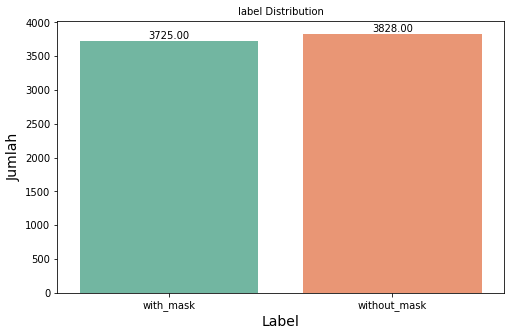

In [13]:
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    
    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of 
    plt.title(f"{label} Distribution", size=10)
    plt.show()

visualize_data(data, 'label')

From the visualize dataset we got a balance data

# v. Data Preprocessing

In [14]:
# Split the data

train_df, test_df = train_test_split(data, test_size=0.15, random_state=34)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=34)
print('Train Size: ', train_df.shape)
print('Val Size: ',val_df.shape)
print('Test Size: ',test_df.shape)

Train Size:  (5457, 2)
Val Size:  (963, 2)
Test Size:  (1133, 2)


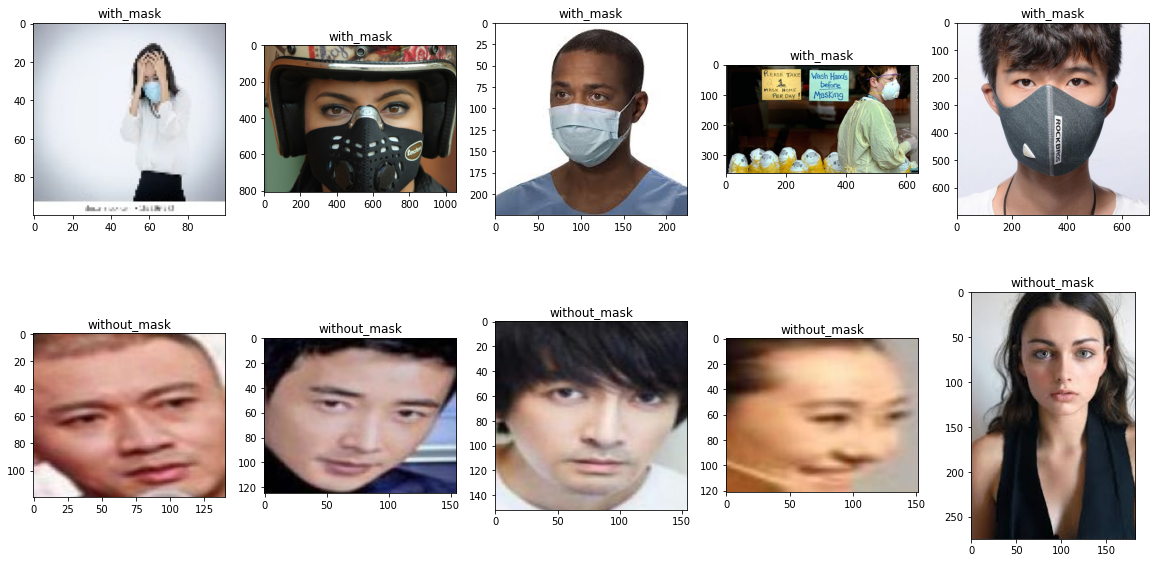

In [15]:
with_samples = (train_df[train_df['label']=="with_mask"]['images'].iloc[:5]).tolist()
without_samples = (train_df[train_df['label']=='without_mask']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(with_samples + without_samples)

We can see the sample images with mask and without mask

# vi. Model Definition

In [16]:
img_height = 120
img_width = 120
SEED = 34
BATCH = 32

# to stable the notebook
np.random.seed(34)
tf.random.set_seed(34)

In [17]:
#augmented the data
train_datagen= ImageDataGenerator(
    rescale= 1./255, #normalization pixel
    rotation_range= 0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True

)

val_datagen= ImageDataGenerator(rescale= 1./255,
    rotation_range= 0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen= ImageDataGenerator(rescale= 1./255,
    rotation_range= 0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

Here's to normalize the data pixel

In [18]:
# access to dataframe
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

ds_val = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

ds_test = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 5457 validated image filenames belonging to 2 classes.
Found 963 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.


In [19]:
ds_train.class_indices

{'with_mask': 0, 'without_mask': 1}

Here we know the definition:
- 0 mean 'with mask'
- 1 mean 'without mask'

In [21]:
# callback
callbacks_df= [
               EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1),
               ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True)
               ]

# vii. Model Training

In [22]:
input= [img_height,img_width,3]
# Made the architecture sequential API
model_hasil= Sequential()

model_hasil.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input))
model_hasil.add(MaxPooling2D(pool_size=2, strides=2))

model_hasil.add(Flatten())
model_hasil.add(Dense(units=128, activation='relu'))
model_hasil.add(Dense(units=2, activation='softmax'))

In [23]:
model_hasil.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 111392)            0         
                                                                 
 dense (Dense)               (None, 128)               14258304  
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 14,259,458
Trainable params: 14,259,458
Non-trainable params: 0
____________________________________________

In [24]:
model_hasil.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
history= model_hasil.fit(ds_train, batch_size=BATCH, epochs=20, validation_data=ds_val,
                         callbacks= callbacks_df, verbose=1)

Epoch 1/20
171/171 [==============================] - 48s 210ms/step - loss: 1.1144 - accuracy: 0.7347 - val_loss: 0.4169 - val_accuracy: 0.8266
Epoch 2/20
171/171 [==============================] - 54s 316ms/step - loss: 0.4078 - accuracy: 0.8283 - val_loss: 0.3581 - val_accuracy: 0.8546
Epoch 3/20
171/171 [==============================] - 34s 199ms/step - loss: 0.3793 - accuracy: 0.8391 - val_loss: 0.3932 - val_accuracy: 0.8235
Epoch 4/20
171/171 [==============================] - 34s 201ms/step - loss: 0.3627 - accuracy: 0.8499 - val_loss: 0.3768 - val_accuracy: 0.8442
Epoch 5/20
171/171 [==============================] - 35s 207ms/step - loss: 0.3563 - accuracy: 0.8481 - val_loss: 0.3493 - val_accuracy: 0.8536
Epoch 6/20
171/171 [==============================] - 34s 201ms/step - loss: 0.3431 - accuracy: 0.8569 - val_loss: 0.3257 - val_accuracy: 0.8588
Epoch 7/20
171/171 [==============================] - 34s 201ms/step - loss: 0.3240 - accuracy: 0.8587 - val_loss: 0.3584 - val_ac

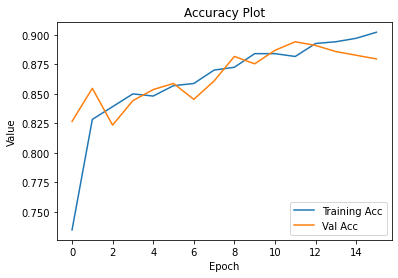

In [26]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()


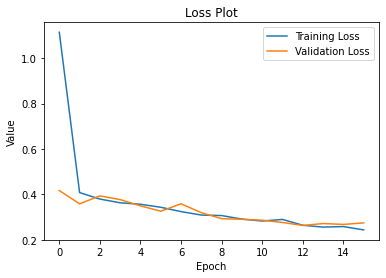

In [27]:
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [28]:
model_evaluate = model_hasil.evaluate(ds_val)

print('Model Evaluate - 1                       : ', model_evaluate)

31/31 [==============================] - 5s 171ms/step - loss: 0.2835 - accuracy: 0.8816
Model Evaluate - 1                       :  [0.2834970951080322, 0.881619930267334]


In [29]:
# Made the architecture sequential API
model_a= Sequential()

model_a.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=input))
model_a.add(MaxPooling2D(pool_size=2, strides=2))

model_a.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input))
model_a.add(MaxPooling2D(pool_size=2, strides=2))
model_a.add(Flatten())
model_a.add(Dense(units=128, activation='relu'))
model_a.add(Dense(units=64, activation='relu'))
model_a.add(Dense(units=2, activation='softmax'))

In [30]:
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 59, 59, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [31]:
model_a.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
history_a= model_a.fit(ds_train, batch_size=BATCH, epochs=20, validation_data=ds_val,
                         callbacks= callbacks_df, verbose=1)

Epoch 1/20
171/171 [==============================] - 34s 194ms/step - loss: 0.5124 - accuracy: 0.7607 - val_loss: 0.4415 - val_accuracy: 0.8027
Epoch 2/20
171/171 [==============================] - 33s 194ms/step - loss: 0.4045 - accuracy: 0.8279 - val_loss: 0.3833 - val_accuracy: 0.8442
Epoch 3/20
171/171 [==============================] - 33s 193ms/step - loss: 0.3670 - accuracy: 0.8395 - val_loss: 0.3524 - val_accuracy: 0.8401
Epoch 4/20
171/171 [==============================] - 33s 194ms/step - loss: 0.3433 - accuracy: 0.8521 - val_loss: 0.3634 - val_accuracy: 0.8474
Epoch 5/20
171/171 [==============================] - 33s 195ms/step - loss: 0.3373 - accuracy: 0.8565 - val_loss: 0.3700 - val_accuracy: 0.8463
Epoch 6/20
171/171 [==============================] - 34s 196ms/step - loss: 0.3201 - accuracy: 0.8629 - val_loss: 0.2945 - val_accuracy: 0.8744
Epoch 7/20
171/171 [==============================] - 34s 198ms/step - loss: 0.2875 - accuracy: 0.8783 - val_loss: 0.3044 - val_ac

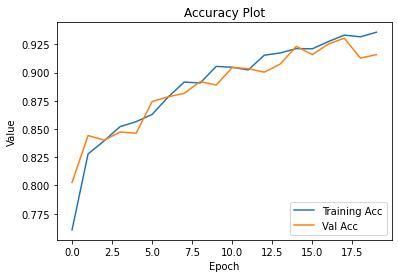

In [33]:
plt.plot(history_a.history['accuracy'], label='Training Acc')
plt.plot(history_a.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

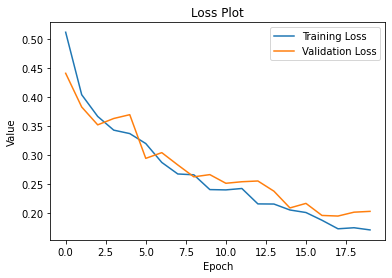

In [34]:
#loss train & validation
plt.plot(history_a.history['loss'], label='Training Loss')
plt.plot(history_a.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [35]:
modela_evaluate = model_a.evaluate(ds_val)

print('Model Evaluate - 1                       : ', model_evaluate)
print('Model Evaluate - a                       : ', modela_evaluate)

31/31 [==============================] - 5s 167ms/step - loss: 0.2410 - accuracy: 0.9045
Model Evaluate - 1                       :  [0.2834970951080322, 0.881619930267334]
Model Evaluate - a                       :  [0.2409537434577942, 0.9044651985168457]


# viii. Model Evaluation

In [36]:
modela_evaluate = model_a.evaluate(ds_val)

print('Model Evaluate - 1                       : ', model_evaluate)
print('Model Evaluate - a                       : ', modela_evaluate)

31/31 [==============================] - 5s 167ms/step - loss: 0.2063 - accuracy: 0.9180
Model Evaluate - 1                       :  [0.2834970951080322, 0.881619930267334]
Model Evaluate - a                       :  [0.20633085072040558, 0.9179646968841553]


In [40]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model_hasil.predict(ds_test)
y_pred = np.argmax(y_pred, axis=1) #pick class with highest  probability

print(classification_report(ds_test.classes, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.87      0.90       551
           1       0.89      0.94      0.91       582

    accuracy                           0.91      1133
   macro avg       0.91      0.91      0.91      1133
weighted avg       0.91      0.91      0.91      1133



In [41]:
y_pred = model_a.predict(ds_test)
y_pred = np.argmax(y_pred, axis=1) #pick class with highest  probability

print(classification_report(ds_test.classes, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.87      0.91       551
           1       0.89      0.96      0.92       582

    accuracy                           0.92      1133
   macro avg       0.92      0.92      0.92      1133
weighted avg       0.92      0.92      0.92      1133



The model got improvement in loss and small different in accuracy point, the loss point improve from 0.28 to 0.20 so i choose model number two. The classification report looks good too from model number one, it improve almost on all aspects.

# ix. Model Saving

In [55]:
# save model
model_a.save("cnn_mask.h5")

# load model
from tensorflow.keras.models import load_model

model_cnn = load_model("cnn_mask.h5")

In [56]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 59, 59, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

# x. Model Inference

Saving istockphoto-1215583521-612x612.jpg to istockphoto-1215583521-612x612.jpg


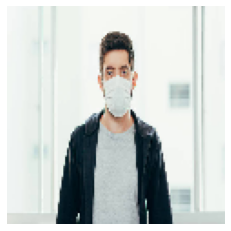

[[1. 0.]]
with mask


In [54]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # Predict with upload the images
  path = fn
  img = image.load_img(path, target_size=(120,120))
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_a.predict(images)
  print(classes) 
  if classes[0][0] == 0:
    print('without mask')
  else:
    print('with mask')


# xi. Conclusion

Conclusion that we got from this project is do the trial and error so we can get the best paramater for the best result, start from import libraries that we need, normalize the data pixel, untill tune the paramaters to get model improvement.

The result we got from this poject:

- Normalize the pixel data
- Do the trial and error for best result paramater
- Used CNN tensorflow with around 92% of accuracy and 20% loss
- Get the best model prediction